## Лабораторна робота 2 з ІСППР (варіант 26)
### Виконали студенти групи КІ-31мп Шабо О.А. та Сотник Д.C.

In [391]:
import torch
import random
import gc
import os

import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import itertools as it

from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from torch.optim import Adam

In [392]:
if torch.cuda.is_available():
    print("PyTorch GPU is available")
else:
    print("PyTorch GPU is not available")
DEVICE = "cuda"

PyTorch GPU is available


In [393]:
RANDOM_SEED = 10

# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(RANDOM_SEED)
# Set python seed
random.seed(RANDOM_SEED)
# Set numpy seed
np.random.seed(RANDOM_SEED)

torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(RANDOM_SEED)

In [394]:
df = pd.read_csv('plate.csv')

df.head()

,Date,Issued,Lowest,Avg,Applicants
0,Jan-02,1400,13600,14735,3718
1,Feb-02,1800,13100,14057,4590
2,Mar-02,2000,14300,14662,5190
3,Apr-02,2300,16000,16334,4806
4,May-02,2350,17800,18357,4665


In [395]:
# Select features and target for modeling
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')

features = df[['Issued', 'Avg', 'Applicants']]
target = df['Lowest']

# Normalize features
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Split the data
split_index = int(len(df) * 0.25)
X_train = features_normalized[split_index:]
y_train = target.values[split_index:]
X_test = features_normalized[:split_index]
y_test = target.values[:split_index]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshaping for a single target
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [396]:
X_train_tensor.shape

torch.Size([153, 3])

In [397]:
y_train_tensor.shape

torch.Size([153, 1])

In [398]:
class BasicRNN():
    def fit(self, X_train, y_train, X_test, y_test, learning_rate=0.01,
            num_epochs=100, batch_size=32, verbose=True, optimizer_class=Adam,
            loss_fn=nn.MSELoss):
        optimizer = optimizer_class(self.parameters(), lr=learning_rate)
        criterion = loss_fn()

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        test_losses = []

        for epoch in tqdm(range(num_epochs), disable=not verbose):
            self.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)

                optimizer.zero_grad()
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * X_batch.size(0)  # Correct loss calculation
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            test_loss = self.evaluate(test_loader, criterion)
            test_losses.append(test_loss)

            if verbose and (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        self.train_losses = train_losses
        self.test_losses = test_losses
        gc.collect()

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()
        plt.show()

    def plot_data_and_prediction(self, df):
        _, ax = plt.subplots()
        # Plot real data
        lowest_scaler = MinMaxScaler().fit(df['Lowest'].values.reshape(-1, 1))

        lowest_unscaled = lowest_scaler.inverse_transform(df['Lowest'].values.reshape(-1, 1)).flatten()
        ax.plot(df['Date'].values, df['Lowest'])
        
        # Plot predicted data
        X = torch.tensor(df.drop(['Date', 'Lowest'], axis=1).values, dtype=torch.float32).to(DEVICE)
        y_pred = self.forward(X).detach()

        y_pred_unscaled = lowest_scaler.inverse_transform(y_pred.cpu().numpy().reshape(-1, 1)).flatten()
    
        ax.plot(df['Date'].values, y_pred_unscaled, color='red', label='Prediction')
        
        # Modify x-axis ticks
        ax.set_xlabel("Date")
        ax.set_ylabel("Lowest Price")
        ax.set_title('Data and Prediction')
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        
        plt.show()

    def evaluate(self, data_loader, criterion):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                total_loss += loss.item() * X_batch.size(0)  # Correct loss calculation
        return total_loss / len(data_loader.dataset)
    

In [399]:
class RNNModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_length):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.seq_length = seq_length

    def forward(self, x):
        # If there are only 2 dimensions, we add a seq_length dimension.
        # But, this might not be necessary depending on how your data is structured.
        if x.dim() == 2:
            x = x.unsqueeze(1)  # This can potentially misalign data if seq_length > 1.
        x = x.to(DEVICE)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Takes the output of the last sequence step
        return out

    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, seq_length, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, seq_length=seq_length).to(DEVICE)
            model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

            test_dataset = TensorDataset(X_test, y_test)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
            val_loss = model.evaluate(test_loader, criterion)

            if val_loss < best_loss:
                best_loss = val_loss
                best_params = params
                best_model = deepcopy(model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [400]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (hidden, cell) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, seq_length, batch_size = params
            input_dim = X_train.shape[-1]  
            output_dim = y_train.shape[-1] 
            
            model = LSTMDeepModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, seq_length=seq_length, num_layers=2).to(DEVICE)
            model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

            test_dataset = TensorDataset(X_test, y_test)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
            val_loss = model.evaluate(test_loader, criterion)

            if val_loss < best_loss:
                best_loss = val_loss
                best_params = params
                best_model = deepcopy(model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [401]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, seq_length, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, seq_length=seq_length).to(DEVICE)
            model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

            test_dataset = TensorDataset(X_test, y_test)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
            val_loss = model.evaluate(test_loader, criterion)

            if val_loss < best_loss:
                best_loss = val_loss
                best_params = params
                best_model = deepcopy(model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [402]:
parameter_grid = {
    'lr': [0.01],
    'hidden_dim': [100],
    'seq_length': [10],
    'batch_size': [64]
}

# parameter_grid = {
#     'lr': [0.1],
#     'hidden_dim': [25, 50, 75, 100],
#     'seq_length': [10, 20, 30],
#     'batch_size': [16, 32, 64, 128]
# }

(best_rnn_params, best_rnn_model) = RNNModel.find_best_parameters(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, parameter_grid)

  0%|          | 0/1 [00:00<?, ?it/s]

Best parameters found: (0.01, 100, 10, 64), with validation loss: 835546176.0


In [403]:
best_rnn_model.fit(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs=8000, learning_rate=best_rnn_params[0], batch_size=best_rnn_params[3])

  0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 10/8000, Training Loss: 4183229356.3399, Test Loss: 833852160.0000
Epoch 20/8000, Training Loss: 4179544053.9608, Test Loss: 832166656.0000


c:\Users\Dmytro Sotnyk\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:553: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch 30/8000, Training Loss: 4175874111.5817, Test Loss: 830490432.0000
Epoch 40/8000, Training Loss: 4172194829.3856, Test Loss: 828810624.0000
Epoch 50/8000, Training Loss: 4168530515.6601, Test Loss: 827140800.0000
Epoch 60/8000, Training Loss: 4164873413.4379, Test Loss: 825474304.0000
Epoch 70/8000, Training Loss: 4161221389.3856, Test Loss: 823808832.0000
Epoch 80/8000, Training Loss: 4157558981.4379, Test Loss: 822142080.0000
Epoch 90/8000, Training Loss: 4153891130.5621, Test Loss: 820474752.0000
Epoch 100/8000, Training Loss: 4150250961.1503, Test Loss: 818819008.0000
Epoch 110/8000, Training Loss: 4146610388.4967, Test Loss: 817164544.0000
Epoch 120/8000, Training Loss: 4142976565.5425, Test Loss: 815514048.0000
Epoch 130/8000, Training Loss: 4139335007.3725, Test Loss: 813862720.0000
Epoch 140/8000, Training Loss: 4135713330.1961, Test Loss: 812221248.0000
Epoch 150/8000, Training Loss: 4132080462.6405, Test Loss: 810574016.0000
Epoch 160/8000, Training Loss: 4128470353.986

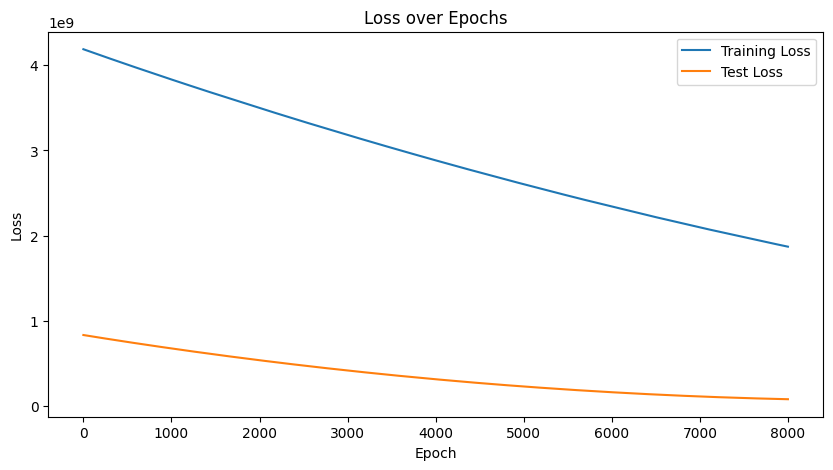

In [404]:
best_model.plot_loss()

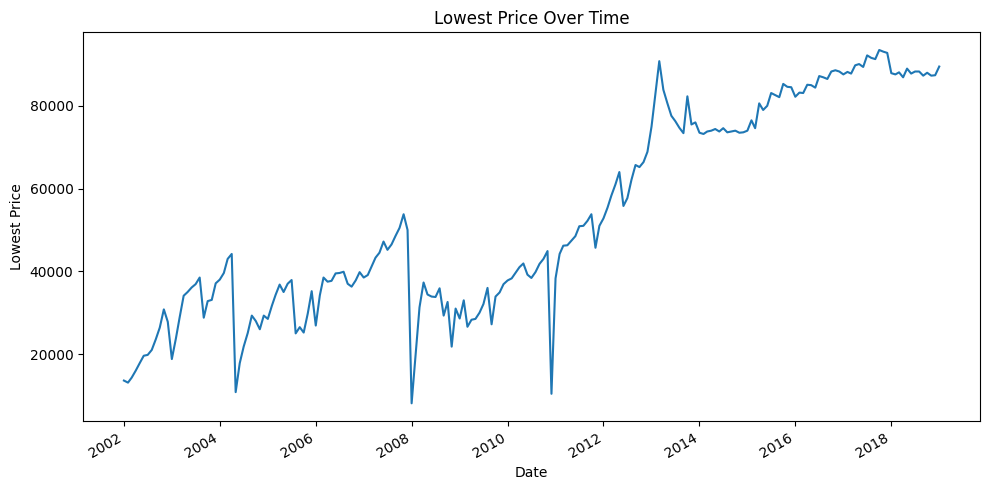

In [405]:
# Plot 'Avg' over time
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Lowest'], label='Lowest Price')
plt.xlabel("Date")
plt.ylabel("Lowest Price")
plt.title("Lowest Price Over Time")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

c:\Users\Dmytro Sotnyk\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:553: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


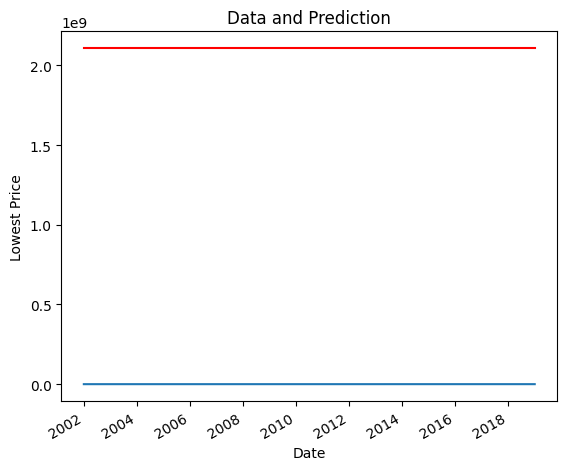

In [406]:
best_model.plot_data_and_prediction(df)